In [31]:
import pandas as pd
import numpy as np
import os

results_dir = "[2] Analyzer Results"

recording_order = [15, 2, 1, 6, 10, 4]# interpulse intervals


size = (10, 5)
male_col = "#1f77b4"
female_col = "#ff7f0e"


prepulse_intensity = {

    "ASR_control":      120,
    "gap_depth":        30,
    "gap_duration_10":  60,
    "gap_duration_20":  60,
    "gap_duration_4":   60,
    "gap_duration_50":  60,
    "gap_duration_8":   60,
    "offset_ASR":       0,
    "offset_PPI_10":    0,
    "offset_PPI_12":    0,
    "offset_PPI_14":    0,
    "offset_PPI_16":    0,
    "offset_PPI_18":    0,
    "offset_PPI_20":    0,
    "offset_PPI_4":     0,
    "offset_PPI_6":     0,
    "offset_PPI_8":     0,
    "offset_PPI_50":    0,
    "tone_in_noise":    80
}
# ...existing code...

# ...existing code...
dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    df = pd.read_excel(file_path)

    # Rename columns: AUC -> peakValue, and existing peakValue -> REPLACED
    cols = list(df.columns)
    if 'AUC' in cols and 'peakValue' in cols:
        # Avoid name collision: temporarily rename existing peakValue, then rename AUC, then finalize
        df = df.rename(columns={'peakValue': 'peakValue_ORIG'})
        df = df.rename(columns={'AUC': 'peakValue'})
        df = df.rename(columns={'peakValue_ORIG': 'REPLACED'})
    else:
        # Simple renames when only one of the columns exists
        rename_map = {}
        if 'AUC' in cols:
            rename_map['AUC'] = 'peakValue'
        if 'peakValue' in cols:
            rename_map['peakValue'] = 'REPLACED'
        if rename_map:
            df = df.rename(columns=rename_map)

    if key.endswith('_FIT'):
        dfs_fit[key] = df
    else:
        dfs[key] = df

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
# ...existing code...
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: []
Found 13 raw and 0 fit dataframes in [2] Analyzer Results.

Found 18 experiments, 6 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, REPLACED, PTPA, PTTA, RMS, peakValue
 animal, sex, date, experiment


In [32]:
# Input sex for every animal
sex_dict = {
    "1":    "female",
    "2":    "male",
    "4":    "male",
    "6":    "female",
    "10":   "female",
    "15":   "male"
}

---
Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset
---

In [33]:
# get S from ASR Control
# get PPS from PPI experiments
# get PPSoffset from offset experiments

#calculate %PPI and %PPIoffset

#split all by date and sex

In [34]:
# --- Collect rows for each experiment type, grouped by animal and date ---

def extract_animal(row):
    # Try to get animal from 'animal' column, else from 'experiment' string
    if 'animal' in row and pd.notna(row['animal']):
        return str(row['animal'])
    if 'experiment' in row and isinstance(row['experiment'], str):
        import re
        match = re.search(r'Animal(\d+)', row['experiment'])
        if match:
            return f'Animal{match.group(1)}'
    return None

def average_peakvalue(val):
    # If val is a list, average it; else, convert to float
    if isinstance(val, list):
        floats = []
        for x in val:
            try:
                floats.append(float(x))
            except Exception:
                continue
        return np.nanmean(floats) if floats else np.nan
    try:
        return float(val)
    except Exception:
        # Try to convert from string representation of a list
        if isinstance(val, str) and val.startswith('[') and val.endswith(']'):
            import ast
            try:
                floats = [float(x) for x in ast.literal_eval(val)]
                return np.nanmean(floats) if floats else np.nan
            except Exception:
                return np.nan
        return np.nan
# ...existing code...

def collect_rows(dfs, experiment_filter, startswith=None):
    rows = []
    for df in dfs.values():
        if {'experiment', 'peakValue', 'date'}.issubset(df.columns):
            if startswith:
                mask = df['experiment'].str.startswith(startswith)
            else:
                mask = df['experiment'].isin(experiment_filter)
            for _, row in df[mask].iterrows():
                animal = extract_animal(row)
                if animal:
                    rows.append({
                        'experiment': row['experiment'],
                        'date': row['date'],
                        'animal': animal,
                        'peakValue': average_peakvalue(row['peakValue'])
                    })
    return rows

ctrl_rows   = collect_rows(dfs, ['ASR_control'])
ttn_rows    = collect_rows(dfs, ['tone_in_noise'])
mix_rows    = collect_rows(dfs, [], startswith=None)
gap_rows    = collect_rows(dfs, [], startswith='gap_duration')
offset_rows = collect_rows(dfs, [], startswith='offset_PPI')

# For mix, exclude certain experiments
excluded = {'ASR_control', 'tone_in_noise', 'offset_ASR', 'gap_depth'}
mix_rows = []
for df in dfs.values():
    if {'experiment', 'peakValue', 'date'}.issubset(df.columns):
        mask = ~df['experiment'].isin(excluded)
        for _, row in df[mask].iterrows():
            animal = extract_animal(row)
            if animal:
                mix_rows.append({
                    'experiment': row['experiment'],
                    'date': row['date'],
                    'animal': animal,
                    'peakValue': average_peakvalue(row['peakValue'])
                })

# gap_depth
gap_depth_rows = collect_rows(dfs, ['gap_depth'])

print(f"ASR_control rows: {len(ctrl_rows)}")
print(f"tone_in_noise rows: {len(ttn_rows)}")
print(f"gap_duration rows: {len(gap_rows)}")
print(f"offset_PPI rows: {len(offset_rows)}")
print(f"gap_depth rows: {len(gap_depth_rows)}")

# DataFrames
# ...existing code...
# DataFrames
ctrl_df      = pd.DataFrame(ctrl_rows)
tin_df       = pd.DataFrame(ttn_rows)
gap_df       = pd.DataFrame(gap_rows)
offset_df    = pd.DataFrame(offset_rows)
gd_df        = pd.DataFrame(gap_depth_rows)

# Aggregate ASR_control to one row per (animal, date) by averaging repetitions
ctrl_df = ctrl_df.groupby(['animal', 'date'], as_index=False).agg({
    'peakValue': 'mean'
})

# (optional) quick check
print(f"ASR_control unique (animal,date) pairs: {len(ctrl_df)}")
# ...existing code...

ASR_control rows: 86
tone_in_noise rows: 90
gap_duration rows: 432
offset_PPI rows: 882
gap_depth rows: 96
ASR_control unique (animal,date) pairs: 18


In [35]:
print("ASR_control DataFrame shape:", ctrl_df)

ASR_control DataFrame shape:       animal     date    peakValue
0    Animal1  April16   601.044000
1    Animal1   June26  1587.215000
2    Animal1    May20   736.305500
3   Animal10  April16   700.138000
4   Animal10   June26  1215.238000
5   Animal10    May20  1111.054667
6   Animal15  April16  1428.457222
7   Animal15   June26  3699.328000
8   Animal15    May20  1939.926000
9    Animal2  April16  2467.682000
10   Animal2   June26  3580.004000
11   Animal2    May20  2468.272000
12   Animal4  April16  1474.252000
13   Animal4   June26  1678.694000
14   Animal4    May20  2419.806944
15   Animal6  April16   802.308667
16   Animal6   June26  1941.196000
17   Animal6    May20  1128.332000


In [36]:
# ...existing code...
def calc_percent_ppi_per_animal_date(ctrl_df, exp_df, label):
    # Merge on animal and date to align S and PPS
    merged = pd.merge(
        exp_df, ctrl_df,
        on=['animal', 'date'],
        suffixes=('_pps', '_s')
    )
    # Only keep rows with valid peakValues
    merged = merged[pd.notna(merged['peakValue_s']) & pd.notna(merged['peakValue_pps']) & (merged['peakValue_s'] != 0)]
    # Calculate %PPI as 100 * (S - PPS) / S
    merged['percent_ppi'] = 100 * (merged['peakValue_s'] - merged['peakValue_pps']) / merged['peakValue_s']

    # Summary: counts and averages only (do not print the individual rows)
    total = len(merged)
    neg_count = int((merged['percent_ppi'] < 0).sum())
    avg_ppi = merged['percent_ppi'].mean() if total > 0 else float('nan')
    print(f"\n{label}: negative %PPI = {neg_count} / {total}, mean %PPI = {avg_ppi:.2f}")

    return merged[['animal', 'date', 'percent_ppi']]

# Calculate %PPI for each experiment type
ppi_tin = calc_percent_ppi_per_animal_date(ctrl_df, tin_df, "tone_in_noise")
ppi_gap = calc_percent_ppi_per_animal_date(ctrl_df, gap_df, "gap_duration")
ppi_offset = calc_percent_ppi_per_animal_date(ctrl_df, offset_df, "offset_PPI")
ppi_gd = calc_percent_ppi_per_animal_date(ctrl_df, gd_df, "gap_depth")
# ...existing code...


tone_in_noise: negative %PPI = 8 / 90, mean %PPI = 37.61

gap_duration: negative %PPI = 172 / 432, mean %PPI = -0.32

offset_PPI: negative %PPI = 164 / 882, mean %PPI = 14.78

gap_depth: negative %PPI = 56 / 96, mean %PPI = -7.24


---

In [37]:
def add_sex_column(ppi_df):
    # Add a 'sex' column using the sex_dict
    ppi_df = ppi_df.copy()
    ppi_df['sex'] = ppi_df['animal'].str.extract(r'(\d+)')[0].map(sex_dict)
    return ppi_df

def print_ppi_stats(ppi_df, label):
    # Calculate averages by sex and overall
    avg_male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].mean()
    avg_female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].mean()
    avg_overall = ppi_df['percent_ppi'].mean()
    print(f"\n{label} averages:")
    print(f"  Male:   {avg_male:.2f}")
    print(f"  Female: {avg_female:.2f}")
    print(f"  Overall:{avg_overall:.2f}")

# Add sex column to each %PPI dataframe
ppi_tin_sex = add_sex_column(ppi_tin)
ppi_gap_sex = add_sex_column(ppi_gap)
ppi_offset_sex = add_sex_column(ppi_offset)
ppi_gd_sex = add_sex_column(ppi_gd)

# Print averages
print_ppi_stats(ppi_tin_sex, "tone_in_noise")
print_ppi_stats(ppi_gap_sex, "gap_duration")
print_ppi_stats(ppi_offset_sex, "offset_PPI")
print_ppi_stats(ppi_gd_sex, "gap_depth")


tone_in_noise averages:
  Male:   33.76
  Female: 41.63
  Overall:37.61

gap_duration averages:
  Male:   -2.67
  Female: 2.03
  Overall:-0.32

offset_PPI averages:
  Male:   10.94
  Female: 18.61
  Overall:14.78

gap_depth averages:
  Male:   -16.41
  Female: 2.71
  Overall:-7.24


In [38]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def test_sex_difference(ppi_df, label):
    male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].dropna()
    female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].dropna()
    print(f"\n{label} - Shapiro-Wilk normality test:")
    stat_m, p_m = shapiro(male)
    stat_f, p_f = shapiro(female)
    print(f"  Male:   W={stat_m:.3f}, p={p_m:.3f}")
    print(f"  Female: W={stat_f:.3f}, p={p_f:.3f}")
    # If both groups are normal, use t-test; else, use Mann-Whitney U
    if p_m > 0.05 and p_f > 0.05:
        stat, p = ttest_ind(male, female, nan_policy='omit')
        print("  Parametric t-test:")
    else:
        stat, p = mannwhitneyu(male, female, alternative='two-sided')
        print("  Non-parametric Mann-Whitney U test:")
    print(f"  Statistic={stat:.3f}, p={p:.3f}")

# Run for each experiment
test_sex_difference(ppi_tin_sex, "tone_in_noise")
test_sex_difference(ppi_gap_sex, "gap_duration")
test_sex_difference(ppi_offset_sex, "offset_PPI")
test_sex_difference(ppi_gd_sex, "gap_depth")


tone_in_noise - Shapiro-Wilk normality test:
  Male:   W=0.755, p=0.000
  Female: W=0.935, p=0.015
  Non-parametric Mann-Whitney U test:
  Statistic=980.000, p=0.799

gap_duration - Shapiro-Wilk normality test:
  Male:   W=0.841, p=0.000
  Female: W=0.879, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=22572.000, p=0.560

offset_PPI - Shapiro-Wilk normality test:
  Male:   W=0.943, p=0.000
  Female: W=0.845, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=73808.000, p=0.000

gap_depth - Shapiro-Wilk normality test:
  Male:   W=0.881, p=0.000
  Female: W=0.925, p=0.006
  Non-parametric Mann-Whitney U test:
  Statistic=656.000, p=0.000


In [39]:
from scipy.stats import mannwhitneyu

def gap_depth_effect_strength(ppi_df):
    male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].dropna()
    female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].dropna()
    u_stat, p_val = mannwhitneyu(male, female, alternative='two-sided')
    # Rank-biserial correlation: r = 1 - (2U) / (n1*n2)
    n1, n2 = len(male), len(female)
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    print("\ngap_depth effect strength:")
    print(f"  Male mean:   {male.mean():.2f}")
    print(f"  Female mean: {female.mean():.2f}")
    print(f"  Mann-Whitney U statistic: {u_stat:.0f}, p-value: {p_val:.3g}")
    print(f"  Rank-biserial correlation (effect size): {rbc:.3f}")

gap_depth_effect_strength(ppi_gd_sex)


gap_depth effect strength:
  Male mean:   -16.41
  Female mean: 2.71
  Mann-Whitney U statistic: 656, p-value: 0.000294
  Rank-biserial correlation (effect size): 0.430


---

In [40]:
# ...existing code...
import re
from scipy.stats import kruskal, shapiro, levene, f_oneway
import numpy as np

def extract_trailing_number(exp_name):
    # Extract trailing number from experiment name (e.g., gap_duration_10 -> 10)
    match = re.search(r'_(\d+)$', exp_name)
    return int(match.group(1)) if match else None

def add_trailing_number_column(df, exp_prefix):
    df = df.copy()
    df['trailing_number'] = df['experiment'].apply(
        lambda x: extract_trailing_number(x) if isinstance(x, str) and x.startswith(exp_prefix) else None
    )
    return df.dropna(subset=['trailing_number'])

# Prepare gap_duration and offset_PPI dataframes with trailing number
gap_df_num = add_trailing_number_column(gap_df, 'gap_duration')
offset_df_num = add_trailing_number_column(offset_df, 'offset_PPI')

def test_trailing_number_effect(ppi_df, label):
    # collect non-empty groups
    groups_info = []
    numbers = sorted(ppi_df['trailing_number'].dropna().unique())
    print(f"\n{label} - group summaries and normality (Shapiro-Wilk):")
    for num in numbers:
        vals = ppi_df[ppi_df['trailing_number'] == num]['percent_ppi'].dropna()
        n = len(vals)
        mean = vals.mean() if n > 0 else float('nan')
        if n >= 3:
            W, p_sh = shapiro(vals)
            shapiro_p = p_sh
            normal = (p_sh > 0.05)
        else:
            W, shapiro_p = (np.nan, np.nan)
            normal = False  # treat small groups as non-normal for decision
        print(f"  {label} {num}: n={n}, mean={mean:.2f}, Shapiro p={shapiro_p if not np.isnan(shapiro_p) else 'NA'}")
        if n > 0:
            groups_info.append({'num': num, 'vals': vals.values, 'n': n, 'mean': mean, 'shapiro_p': shapiro_p, 'normal': normal})

    if len(groups_info) < 2:
        print("  Not enough groups for a test.")
        return

    # decide test: require all groups have n>=3 and pass Shapiro to attempt ANOVA
    all_normal = all(g['normal'] for g in groups_info)
    sufficient_n = all(g['n'] >= 3 for g in groups_info)

    groups_arrays = [g['vals'] for g in groups_info]

    if sufficient_n and all_normal:
        # check homogeneity of variances
        lev_stat, lev_p = levene(*groups_arrays)
        print(f"  Levene p (equal variances test) = {lev_p:.3g}")
        if lev_p > 0.05:
            stat, p = f_oneway(*groups_arrays)
            print(f"  Using one-way ANOVA: F={stat:.3f}, p={p:.3g}")
            return {'test': 'ANOVA', 'stat': stat, 'p': p, 'levene_p': lev_p}
        else:
            # variances unequal -> fall back to Kruskal-Wallis (nonparametric)
            stat, p = kruskal(*groups_arrays)
            print(f"  Variances unequal -> using Kruskal-Wallis: H={stat:.3f}, p={p:.3g}")
            return {'test': 'Kruskal', 'stat': stat, 'p': p, 'levene_p': lev_p}
    else:
        stat, p = kruskal(*groups_arrays)
        print(f"  Non-normal or small groups -> using Kruskal-Wallis: H={stat:.3f}, p={p:.3g}")
        return {'test': 'Kruskal', 'stat': stat, 'p': p}

# Calculate %PPI for gap_duration and offset_PPI with trailing number (merge expects ctrl_df aggregated per (animal,date))
gap_ppi = pd.merge(gap_df_num, ctrl_df, on=['animal', 'date'], suffixes=('_pps', '_s'))
gap_ppi = gap_ppi[pd.notna(gap_ppi['peakValue_s']) & pd.notna(gap_ppi['peakValue_pps']) & (gap_ppi['peakValue_s'] != 0)]
gap_ppi['percent_ppi'] = 100 * (gap_ppi['peakValue_s'] - gap_ppi['peakValue_pps']) / gap_ppi['peakValue_s']

offset_ppi = pd.merge(offset_df_num, ctrl_df, on=['animal', 'date'], suffixes=('_pps', '_s'))
offset_ppi = offset_ppi[pd.notna(offset_ppi['peakValue_s']) & pd.notna(offset_ppi['peakValue_pps']) & (offset_ppi['peakValue_s'] != 0)]
offset_ppi['percent_ppi'] = 100 * (offset_ppi['peakValue_s'] - offset_ppi['peakValue_pps']) / offset_ppi['peakValue_s']

# Run tests (will print group summaries and chosen test)
test_trailing_number_effect(gap_ppi, "gap_duration")
test_trailing_number_effect(offset_ppi, "offset_PPI")
# ...existing code...


gap_duration - group summaries and normality (Shapiro-Wilk):
  gap_duration 4: n=86, mean=-4.44, Shapiro p=2.6319564827391233e-08
  gap_duration 8: n=84, mean=-2.16, Shapiro p=5.50122725355519e-09
  gap_duration 10: n=92, mean=0.97, Shapiro p=1.3233552138932258e-07
  gap_duration 20: n=90, mean=-0.19, Shapiro p=1.0104083842800845e-07
  gap_duration 50: n=80, mean=4.41, Shapiro p=1.5661765528212097e-07
  Non-normal or small groups -> using Kruskal-Wallis: H=9.131, p=0.0579

offset_PPI - group summaries and normality (Shapiro-Wilk):
  offset_PPI 4: n=92, mean=16.89, Shapiro p=0.0012283997078705955
  offset_PPI 6: n=88, mean=13.69, Shapiro p=0.005220034244927392
  offset_PPI 8: n=80, mean=17.91, Shapiro p=0.0015126627165499278
  offset_PPI 10: n=92, mean=16.60, Shapiro p=5.515188739707847e-07
  offset_PPI 12: n=86, mean=18.07, Shapiro p=0.002081048450284577
  offset_PPI 14: n=84, mean=10.55, Shapiro p=3.446678792310492e-05
  offset_PPI 16: n=92, mean=13.94, Shapiro p=1.508157625087939e-1

{'test': 'Kruskal',
 'stat': np.float64(18.145923318216944),
 'p': np.float64(0.03351782143300228)}

In [41]:
from scipy.stats import spearmanr

def test_trailing_number_direction_and_strength(ppi_df, label):
    # Test if %PPI increases or decreases with trailing number (treated as continuous)
    vals = ppi_df[['trailing_number', 'percent_ppi']].dropna()
    corr, p = spearmanr(vals['trailing_number'], vals['percent_ppi'])
    print(f"\n{label} trailing number direction (Spearman correlation):")
    print(f"  Spearman r = {corr:.3f}, p = {p:.3g}")
    if p < 0.05:
        direction = "increases" if corr > 0 else "decreases"
        print(f"  %PPI {direction} with trailing number.")
    else:
        print("  No significant monotonic relationship.")
    # Effect strength: absolute value of correlation coefficient
    print(f"  Effect strength (|r|): {abs(corr):.3f}")

test_trailing_number_direction_and_strength(gap_ppi, "gap_duration")
test_trailing_number_direction_and_strength(offset_ppi, "offset_PPI")


gap_duration trailing number direction (Spearman correlation):
  Spearman r = 0.117, p = 0.0153
  %PPI increases with trailing number.
  Effect strength (|r|): 0.117

offset_PPI trailing number direction (Spearman correlation):
  Spearman r = -0.055, p = 0.106
  No significant monotonic relationship.
  Effect strength (|r|): 0.055


---

In [42]:
# Use the raw data to keep gap/offset length info intact in the combined dataframe

# Add trailing_number to gap_df and offset_df directly from their experiment names
def extract_trailing_number(exp_name):
    import re
    match = re.search(r'_(\d+)$', exp_name)
    return int(match.group(1)) if match else None

gap_df = gap_df.copy()
gap_df['trailing_number'] = gap_df['experiment'].apply(lambda x: extract_trailing_number(x))
offset_df = offset_df.copy()
offset_df['trailing_number'] = offset_df['experiment'].apply(lambda x: extract_trailing_number(x))

# Calculate %PPI for each experiment type, keeping trailing_number for gap/offset
def calc_percent_ppi_per_animal_date_full(ctrl_df, exp_df, label):
    merged = pd.merge(
        exp_df, ctrl_df,
        on=['animal', 'date'],
        suffixes=('_pps', '_s')
    )
    merged = merged[pd.notna(merged['peakValue_s']) & pd.notna(merged['peakValue_pps']) & (merged['peakValue_s'] != 0)]
    merged['percent_ppi'] = 100 * (merged['peakValue_s'] - merged['peakValue_pps']) / merged['peakValue_s']
    merged['experiment'] = label
    # If trailing_number exists, keep it
    if 'trailing_number' in exp_df.columns:
        merged['trailing_number'] = merged['trailing_number']
    else:
        merged['trailing_number'] = None
    return merged

ppi_tin = calc_percent_ppi_per_animal_date_full(ctrl_df, tin_df, "tone_in_noise")
ppi_gap = calc_percent_ppi_per_animal_date_full(ctrl_df, gap_df, "gap_duration")
ppi_offset = calc_percent_ppi_per_animal_date_full(ctrl_df, offset_df, "offset_PPI")
ppi_gd = calc_percent_ppi_per_animal_date_full(ctrl_df, gd_df, "gap_depth")

all_ppi = pd.concat([ppi_tin, ppi_gap, ppi_offset, ppi_gd], ignore_index=True)

print(all_ppi)

         experiment     date    animal  peakValue_pps  peakValue_s  \
0     tone_in_noise  April16   Animal1        415.710   601.044000   
1     tone_in_noise  April16   Animal2       1064.096  2467.682000   
2     tone_in_noise  April16   Animal4        623.110  1474.252000   
3     tone_in_noise  April16   Animal6        602.080   802.308667   
4     tone_in_noise  April16  Animal10        400.026   700.138000   
...             ...      ...       ...            ...          ...   
1495      gap_depth   June26  Animal10        841.020  1215.238000   
1496      gap_depth    May20   Animal1        952.435   736.305500   
1497      gap_depth    May20   Animal2       2892.505  2468.272000   
1498      gap_depth    May20   Animal6       1177.340  1128.332000   
1499      gap_depth    May20  Animal15       2901.140  1939.926000   

      percent_ppi trailing_number  
0       30.835346            None  
1       56.878723            None  
2       57.733820            None  
3       24.9565

In [43]:
# ...existing code...
from scipy.stats import mannwhitneyu
import numpy as np

# Prepare offset %PPI dataframe
df = all_ppi.copy()
if 'trailing_number' not in df.columns:
    df['trailing_number'] = df['experiment'].str.extract(r'_(\d+)$').astype(float)

offset = df[(df['experiment'] == 'offset_PPI') | df['experiment'].str.startswith('offset_PPI')].copy()
offset = offset.dropna(subset=['percent_ppi', 'trailing_number'])
offset['trailing_number'] = offset['trailing_number'].astype(int)

# Define groups
low_offsets  = [4, 6, 8, 10, 12, 14]
high_offsets = [16, 18, 20, 50]

low_vals  = offset[offset['trailing_number'].isin(low_offsets) ]['percent_ppi'].values
high_vals = offset[offset['trailing_number'].isin(high_offsets)]['percent_ppi'].values

print(f"Low offsets  (4,6,8,10):  n={len(low_vals)}, median={np.median(low_vals) if len(low_vals)>0 else 'NA'}")
print(f"High offsets (12..50):     n={len(high_vals)}, median={np.median(high_vals) if len(high_vals)>0 else 'NA'}")

if len(low_vals) == 0 or len(high_vals) == 0:
    print("Not enough data in one of the groups to run the test.")
else:
    # Non-parametric test, alternative='less' checks if low_offsets have lower %PPI than high_offsets
    u_stat, p_val = mannwhitneyu(low_vals, high_vals, alternative='less')
    n1, n2 = len(low_vals), len(high_vals)
    rank_biserial = 1 - (2 * u_stat) / (n1 * n2)
    print(f"Mann-Whitney U (low < high): U={u_stat:.3f}, p={p_val:.3g}")
    print(f"Rank-biserial effect size: {rank_biserial:.3f}")
# ...existing code...

Low offsets  (4,6,8,10):  n=522, median=18.489159249289855
High offsets (12..50):     n=360, median=16.759397483996484
Mann-Whitney U (low < high): U=97856.000, p=0.853
Rank-biserial effect size: -0.041


In [44]:
# ...existing code...
from scipy.stats import mannwhitneyu
import numpy as np

# Prepare offset %PPI dataframe
df = all_ppi.copy()
if 'trailing_number' not in df.columns:
    df['trailing_number'] = df['experiment'].str.extract(r'_(\d+)$').astype(float)

offset = df[(df['experiment'] == 'offset_PPI') | df['experiment'].str.startswith('offset_PPI')].copy()
offset = offset.dropna(subset=['percent_ppi', 'trailing_number'])
offset['trailing_number'] = offset['trailing_number'].astype(int)

# Define groups
low_offsets  = [4, 6, 8, 10]
high_offsets = [12, 14, 16, 18, 20, 50]

low_vals  = offset[offset['trailing_number'].isin(low_offsets) ]['percent_ppi'].values
high_vals = offset[offset['trailing_number'].isin(high_offsets)]['percent_ppi'].values

print(f"Low offsets  (4,6,8,10):  n={len(low_vals)}, median={np.median(low_vals) if len(low_vals)>0 else 'NA'}")
print(f"High offsets (12..50):     n={len(high_vals)}, median={np.median(high_vals) if len(high_vals)>0 else 'NA'}")

if len(low_vals) == 0 or len(high_vals) == 0:
    print("Not enough data in one of the groups to run the test.")
else:
    # Non-parametric test, alternative='less' checks if low_offsets have lower %PPI than high_offsets
    u_stat, p_val = mannwhitneyu(low_vals, high_vals, alternative='less')
    n1, n2 = len(low_vals), len(high_vals)
    rank_biserial = 1 - (2 * u_stat) / (n1 * n2)
    print(f"Mann-Whitney U (low < high): U={u_stat:.3f}, p={p_val:.3g}")
    print(f"Rank-biserial effect size: {rank_biserial:.3f}")
# ...existing code...

Low offsets  (4,6,8,10):  n=352, median=18.72132743899053
High offsets (12..50):     n=530, median=17.57641890902913
Mann-Whitney U (low < high): U=97064.000, p=0.846
Rank-biserial effect size: -0.041


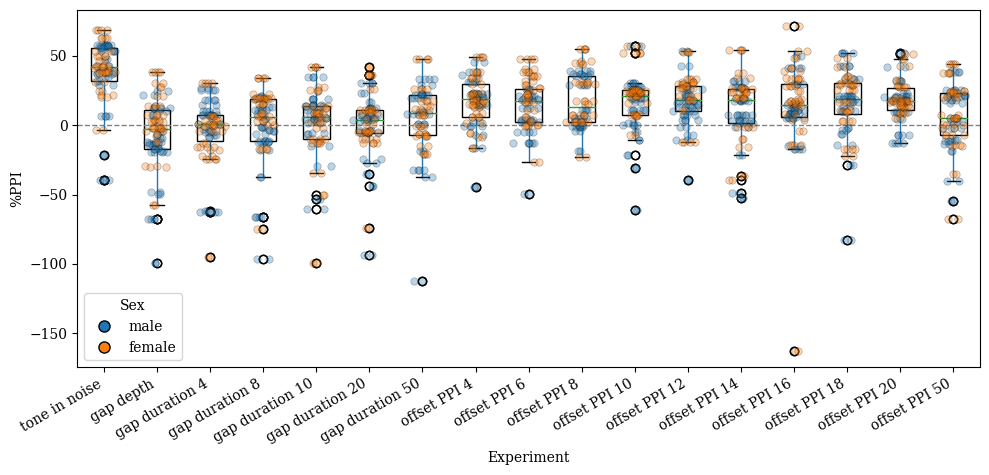

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Use all_ppi as the source DataFrame

def experiment_sort_key(exp):
    if exp == "tone_in_noise":
        return (0, 0)
    if exp == "gap_depth":
        return (1, 0)
    m_gap = re.match(r"gap_duration_(\d+)", exp)
    m_offset = re.match(r"offset_PPI_(\d+)", exp)
    if m_gap:
        return (2, int(m_gap.group(1)))
    elif m_offset:
        return (3, int(m_offset.group(1)))
    else:
        return (4, exp)

# Add sex column using sex_dict and animal number
def add_sex_column(df):
    df = df.copy()
    df['animal_num'] = df['animal'].str.extract(r'(\d+)')[0]
    df['sex'] = df['animal_num'].map(sex_dict)
    return df

all_ppi_plot = add_sex_column(all_ppi.copy())
if 'trailing_number' in all_ppi_plot.columns:
    all_ppi_plot['experiment_full'] = all_ppi_plot.apply(
        lambda row: f"{row['experiment']}_{int(row['trailing_number'])}" if pd.notna(row['trailing_number']) else row['experiment'],
        axis=1
    )
else:
    all_ppi_plot['experiment_full'] = all_ppi_plot['experiment']

experiment_order = sorted(all_ppi_plot['experiment_full'].unique(), key=experiment_sort_key)
all_ppi_plot['experiment_full'] = pd.Categorical(all_ppi_plot['experiment_full'], categories=experiment_order, ordered=True)

# ...existing code...
import matplotlib as mpl
import os

# export folder (change if needed)
export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

# Ensure PGF-safe text settings
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

plt.figure(figsize=size)
ax = plt.gca()

# Boxplot
all_ppi_plot.boxplot(column="percent_ppi", by="experiment_full", ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="white"))

# Scatterplot overlay with male/female colors
color_map = {'male': male_col, 'female': female_col}
for i, exp in enumerate(experiment_order, start=1):
    exp_data = all_ppi_plot[all_ppi_plot["experiment_full"] == exp]
    for sex, color in color_map.items():
        yvals = exp_data[exp_data['sex'] == sex]["percent_ppi"]
        xvals = i + 0.1 * (np.random.randn(len(yvals)))
        ax.scatter(
            xvals, yvals,
            color=color,
            edgecolor="black",
            alpha=0.3,
            s=28,
            linewidth=0.5,
            marker='o',
            zorder=10,
            label=sex if i == 1 else None  # Only label once for legend
        )

plt.ylabel("%PPI")
plt.xlabel("Experiment")
plt.suptitle("")
plt.title("")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(ticks=range(1, len(experiment_order)+1), labels=[str(l).replace("_", r" ") for l in experiment_order], rotation=30, ha='right')
# ...existing code...
handles, labels = ax.get_legend_handles_labels()
# ...existing code...
from matplotlib.lines import Line2D
# Replace autogenerated (alpha'd) handles with opaque proxy markers for the legend
legend_handles = []
legend_labels = []
for sex, color in color_map.items():
    legend_handles.append(Line2D([0], [0],
                                 marker='o',
                                 color='none',
                                 markerfacecolor=color,
                                 markeredgecolor='black',
                                 markersize=8,
                                 linestyle=''))
    legend_labels.append(sex)
plt.legend(legend_handles, legend_labels, title="Sex")
# ...existing code...
plt.tight_layout()

# Save PGF (with PDF fallback)
fig = plt.gcf()
pgf_path = os.path.join(export_folder, "percentPPI_exp.pgf")
pdf_path = os.path.join(export_folder, "percentPPI_exp.pdf")
""" try:
    fig.savefig(pgf_path, format="pgf", bbox_inches='tight')
    print(f"Saved PGF: {pgf_path}")
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches='tight')
    print(f"Saved PDF: {pdf_path}")
 """
plt.show()
# ...existing code...

tone_in_noise trendline slope: 4.4521 (n=6)
gap_depth trendline slope: 3.8573 (n=6)
gap_duration trendline slope: 3.0844 (n=6)
offset_PPI trendline slope: -0.2869 (n=6)
Overall mean trendline slope: 1.3929 (n=6)


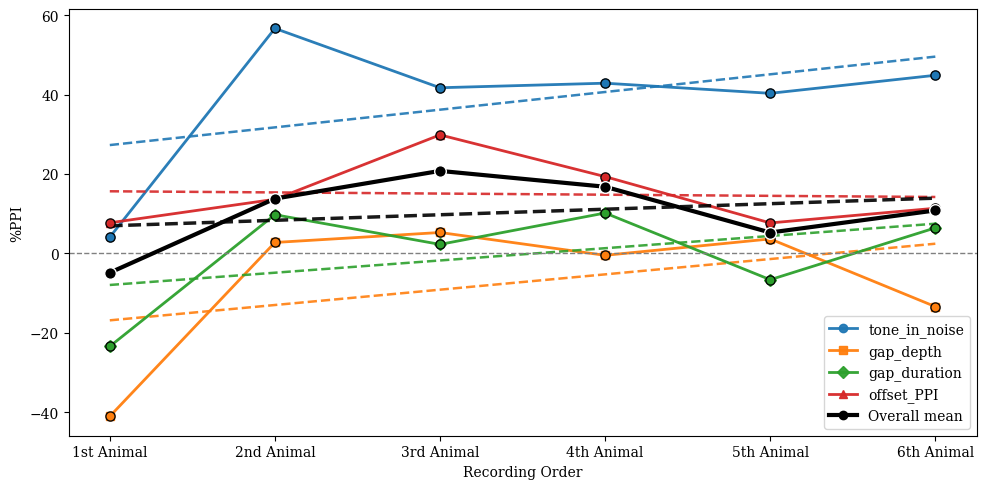

C:\Users\Galahad\AppData\Local\Temp\ipykernel_25128\3873792886.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([_sanitize_text(t) for t in yt])


<Figure size 640x480 with 0 Axes>

In [46]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import pandas as pd
import re

# Use all_ppi as the source DataFrame
recording_order = [15, 2, 1, 6, 10, 4]
animal_order = [f'Animal{num}' for num in recording_order]

# helper: build a grouped experiment name (group gap_duration_* -> gap_duration, offset_PPI_* -> offset_PPI)
df_plot = all_ppi.copy()

def base_experiment_name(exp):
    if not isinstance(exp, str):
        return exp
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    return exp

df_plot['experiment_full'] = df_plot['experiment'].apply(base_experiment_name)

# keep animal as string like 'Animal15' (fall back to regex if needed)
def animal_string(val):
    if pd.isna(val):
        return None
    s = str(val)
    if re.match(r'Animal\d+', s):
        return s
    m = re.search(r'(\d+)', s)
    return f"Animal{m.group(1)}" if m else s

df_plot['animal_id'] = df_plot['animal'].apply(animal_string)

# sort experiments meaningfully (grouped names now)
def experiment_sort_key(exp):
    if exp == "tone_in_noise":
        return (0, 0)
    if exp == "gap_depth":
        return (1, 0)
    if exp == "gap_duration":
        return (2, 0)
    if exp == "offset_PPI":
        return (3, 0)
    return (4, exp)

experiment_order = sorted(df_plot['experiment_full'].unique(), key=experiment_sort_key)

# prepare more distinct colors and markers
n_exp = len(experiment_order)

# combine several listed palettes to maximize distinct hues
pal_names = ['tab10', 'Set1', 'Dark2', 'Paired', 'tab20']
colors_list = []
for pname in pal_names:
    cmap = plt.get_cmap(pname)
    # for ListedColormap the .colors attribute is convenient
    base = getattr(cmap, 'colors', None)
    if base is None:
        base = [cmap(i) for i in range(cmap.N)]
    colors_list.extend([mcolors.to_hex(c) for c in base])

# ensure enough colors, else fill with evenly spaced HSV
if len(colors_list) < n_exp:
    extra = [mcolors.to_hex(plt.cm.hsv(i / n_exp)) for i in range(n_exp - len(colors_list))]
    colors_list.extend(extra)

colors = colors_list[:n_exp]
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '8']

plt.figure(figsize=size)
ax = plt.gca()

# for printing slopes
slopes = {}

# x positions = 1..len(animal_order)
x_all = np.arange(1, len(animal_order) + 1)

for i, exp in enumerate(experiment_order):
    # compute average %PPI per animal in recording order for this experiment
    y = []
    for a in animal_order:
        vals = df_plot[(df_plot['experiment_full'] == exp) & (df_plot['animal_id'] == a)]['percent_ppi'].dropna().values
        y.append(np.nan if len(vals) == 0 else np.nanmean(vals))
    y = np.array(y, dtype=float)

    # plot line (NaNs break the line where data missing)
    ax.plot(x_all, y, marker=markers[i % len(markers)], color=colors[i], linewidth=2,
            label=exp, alpha=0.95)

    # scatter points on top for clarity (use darker edge for contrast)
    ax.scatter(x_all, y, color=colors[i], edgecolor='k', s=44, zorder=6, alpha=0.95)

    # trendline: only if at least 2 valid points
    valid = ~np.isnan(y)
    if valid.sum() > 1:
        xv = x_all[valid]
        yv = y[valid]
        z = np.polyfit(xv, yv, 1)
        p = np.poly1d(z)
        # plot trend only across the span of valid x values
        x_trend = np.linspace(xv.min(), xv.max(), 50)
        ax.plot(x_trend, p(x_trend), linestyle='--', color=colors[i], linewidth=1.8, alpha=0.9)
        slopes[exp] = z[0]
        print(f"{exp} trendline slope: {z[0]:.4f} (n={valid.sum()})")
    else:
        slopes[exp] = np.nan
        print(f"{exp} trendline slope: NA (n={valid.sum()})")

# --- overall mean across experiments per animal ---
avg_by_animal = df_plot.groupby('animal_id')['percent_ppi'].mean()
y_overall = np.array([avg_by_animal.get(a, np.nan) for a in animal_order], dtype=float)

ax.plot(x_all, y_overall, marker='o', color='black', linewidth=3, label='Overall mean', zorder=30)
ax.scatter(x_all, y_overall, color='black', edgecolor='white', s=70, zorder=35)

valid_overall = ~np.isnan(y_overall)
if valid_overall.sum() > 1:
    xv = x_all[valid_overall]
    yv = y_overall[valid_overall]
    z = np.polyfit(xv, yv, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(xv.min(), xv.max(), 50)
    ax.plot(x_trend, p(x_trend), linestyle='--', color='black', linewidth=2.5, alpha=0.9)
    print(f"Overall mean trendline slope: {z[0]:.4f} (n={valid_overall.sum()})")
else:
    print(f"Overall mean trendline slope: NA (n={valid_overall.sum()})")

# ...existing code...
# ...existing code...
def ordinal(n):
    n = int(n)
    if 10 <= (n % 100) <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

ax.set_ylabel('%PPI')
ax.set_xlabel('Recording Order')
ax.set_xticks(x_all)
# use "1st Animal", "2nd Animal", ...
ax.set_xticklabels([f"{ordinal(i)} Animal" for i in range(1, len(animal_order) + 1)])
# ...existing code...
# (removed the following overwrite that set numeric tick labels)
# ax.set_xticklabels([str(i) for i in range(1, len(animal_order)+1)])
# ...existing code...
# ...existing code...
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# ...existing code...
plt.tight_layout()

# Save PGF (with PDF fallback)
import matplotlib as mpl
import os

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

# ...existing code...
# ...existing code...
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import numpy as np

# export folder
export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"
os.makedirs(export_folder, exist_ok=True)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": False,
    "pgf.rcfonts": False,
})

# helper that replaces underscores and avoids raw '%' in text for PGF
def _sanitize_text(s):
    if not isinstance(s, str):
        return s
    s = s.replace('_', ' ')
    # replace percent sign with word form (safe) to avoid LaTeX parsing issues
    s = s.replace('%', '%')
    return s

def sanitize_figure_for_pgf(fig):
    for ax in fig.axes:
        try:
            ax.set_title(_sanitize_text(ax.get_title()))
            ax.set_xlabel(_sanitize_text(ax.get_xlabel()))
            ax.set_ylabel(_sanitize_text(ax.get_ylabel()))
        except Exception:
            pass
        try:
            xt = [lbl.get_text() for lbl in ax.get_xticklabels()]
            ax.set_xticklabels([_sanitize_text(t) for t in xt])
        except Exception:
            pass
        try:
            yt = [lbl.get_text() for lbl in ax.get_yticklabels()]
            ax.set_yticklabels([_sanitize_text(t) for t in yt])
        except Exception:
            pass
        leg = ax.get_legend()
        if leg is not None:
            for t in leg.get_texts():
                try:
                    t.set_text(_sanitize_text(t.get_text()))
                except Exception:
                    pass
    try:
        st = getattr(fig, "_suptitle", None)
        if st is not None:
            st.set_text(_sanitize_text(st.get_text()))
    except Exception:
        pass
    try:
        fig.canvas.draw()
    except Exception:
        pass

# --- Example: recording-order plot (uses existing df_plot, animal_order, etc.) ---
# Ensure ylabel doesn't contain raw '%' which breaks PGF export
ax.set_ylabel('%PPI')   # replace "%PPI" with safe label
ax.set_xlabel('Recording Order')

# get the exact figure object for this axis, sanitize and save
fig = ax.get_figure()
sanitize_figure_for_pgf(fig)

pgf_path = os.path.join(export_folder, "rec_order_ppi.pgf")
pdf_path = os.path.join(export_folder, "rec_order_ppi.pdf")
""" try:
    fig.savefig(pgf_path, format="pgf", bbox_inches="tight")
    print(f"Saved PGF: {pgf_path}")
except Exception as e:
    print(f"PGF save failed ({e}), saving PDF instead.")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF: {pdf_path}") """

plt.show()
# ...existing code...
# ...existing code...

In [47]:
ppi_df = pd.DataFrame(all_ppi)

In [48]:
# ...existing code...
from scipy.stats import spearmanr, kruskal, mannwhitneyu, friedmanchisquare, shapiro, levene, f_oneway, ttest_ind
import numpy as np
import pandas as pd

# aggregate to one value per animal per date (removes within-date pseudoreplication)
df = ppi_df.copy()
agg = df.groupby(['animal', 'date'], as_index=False)['percent_ppi'].mean()

# order dates consistently (try chronological parse, fall back to string)
unique_dates = sorted(
    agg['date'].unique(),
    key=lambda s: pd.to_datetime(s, errors='coerce') if pd.to_datetime(s, errors='coerce') is not pd.NaT else s
)

# build groups: one value per animal per date
groups = [agg[agg['date'] == d]['percent_ppi'].values for d in unique_dates]
counts = [len(g) for g in groups]
means = [np.nanmean(g) if len(g)>0 else np.nan for g in groups]
medians = [np.nanmedian(g) if len(g)>0 else np.nan for g in groups]

print("Date effect on percent_ppi (values = per-animal means):\n")
for d, n, m, md in zip(unique_dates, counts, means, medians):
    print(f"  {d}: n_animals={n}, mean={m:.2f}, median={md:.2f}")

# Shapiro-Wilk normality per date-group (require n>=3 for Shapiro)
shapiro_results = []
print("\nShapiro-Wilk per-date (n>=3):")
for d, g in zip(unique_dates, groups):
    n = len(g)
    if n >= 3:
        try:
            W, p_sh = shapiro(g)
        except Exception as e:
            W, p_sh = (np.nan, np.nan)
        normal = (p_sh > 0.05) if not np.isnan(p_sh) else False
        print(f"  {d}: n={n}, mean={np.nanmean(g):.2f}, W={W:.3f}, p={p_sh:.3g}, normal={normal}")
        shapiro_results.append({'date': d, 'n': n, 'W': W, 'p': p_sh, 'normal': normal, 'vals': g})
    else:
        print(f"  {d}: n={n} (too small for Shapiro, treat as non-normal for decision)")
        shapiro_results.append({'date': d, 'n': n, 'W': np.nan, 'p': np.nan, 'normal': False, 'vals': g})

ng = sum(1 for g in groups if len(g) > 0)
total_n = sum(len(g) for g in groups)
if ng < 2:
    print("\nNeed >=2 dates with data to test.")
else:
    # choose test based on normality and variance homogeneity
    nonempty_groups = [g for g in groups if len(g) > 0]
    nonempty_dates = [r for r in shapiro_results if r['n'] > 0]
    if len(nonempty_groups) == 2:
        # two groups -> t-test if both normal (n>=3) otherwise Mann-Whitney
        g0, g1 = nonempty_groups
        r0, r1 = nonempty_dates[0], nonempty_dates[1]
        if r0['normal'] and r1['normal']:
            lev_stat, lev_p = levene(g0, g1)
            equal_var = (lev_p > 0.05)
            stat, p = ttest_ind(g0, g1, equal_var=equal_var, nan_policy='omit')
            print(f"\nTwo-group parametric t-test (equal_var={equal_var}): t={stat:.3f}, p={p:.3g} (n1={len(g0)}, n2={len(g1)})")
        else:
            stat, p = mannwhitneyu(g0, g1, alternative='two-sided')
            print(f"\nTwo-group nonparametric Mann-Whitney U: U={stat:.3f}, p={p:.3g} (n1={len(g0)}, n2={len(g1)})")
    else:
        # >2 groups -> ANOVA if all normal and sufficient n and variances homogeneous, else Kruskal
        all_normal = all(r['normal'] for r in nonempty_dates)
        sufficient_n = all(r['n'] >= 3 for r in nonempty_dates)
        groups_arrays = [r['vals'] for r in nonempty_dates]
        if sufficient_n and all_normal:
            try:
                lev_stat, lev_p = levene(*groups_arrays)
            except Exception:
                lev_stat, lev_p = (np.nan, np.nan)
            print(f"\nLevene test p = {lev_p if not np.isnan(lev_p) else 'NA'} (homogeneity of variances)")
            if not np.isnan(lev_p) and lev_p > 0.05:
                stat, p = f_oneway(*groups_arrays)
                print(f"One-way ANOVA: F={stat:.3f}, p={p:.3g} (groups={ng}, total_n={total_n})")
            else:
                stat, p = kruskal(*groups_arrays)
                print(f"Kruskal-Wallis (variances unequal or Levene NA): H={stat:.3f}, p={p:.3g} (groups={ng}, total_n={total_n})")
        else:
            # fall back to nonparametric
            if total_n < 3:
                print("\nNot enough total samples for Kruskal-Wallis.")
            else:
                stat, p = kruskal(*groups_arrays)
                print(f"\nKruskal-Wallis: H={stat:.3f}, p={p:.3g} (groups={ng}, total_n={total_n})")

# Spearman on per-date means (monotonic trend across ordered dates)
date_means = np.array([m for m in means])
valid_idx = ~np.isnan(date_means)
if valid_idx.sum() >= 2:
    date_order_map = {d: i for i, d in enumerate(unique_dates)}
    x = np.array([date_order_map[d] for d in unique_dates])[valid_idx]
    y = date_means[valid_idx]
    r, p = spearmanr(x, y)
    print(f"\nSpearman (date order vs per-date mean%PPI): r={r:.3f}, p={p:.3g}")
else:
    print("\nSpearman: need >=2 date means.")

# Friedman test (repeated measures) if same animals present for all dates
pivot = agg.pivot(index='animal', columns='date', values='percent_ppi')
complete = pivot.dropna(axis=0, how='any')  # animals with all dates
if complete.shape[0] >= 2 and complete.shape[1] >= 2:
    arrays = [complete[d].values for d in unique_dates if d in complete.columns]
    if len(arrays) >= 2:
        stat, p = friedmanchisquare(*arrays)
        print(f"\nFriedman (paired across animals present on all dates): chi2={stat:.3f}, p={p:.3g} (n_animals={complete.shape[0]}, dates={len(arrays)})")
else:
    print("\nFriedman: not enough complete repeated data (need >=2 animals with values on all dates).")
# ...existing code...

Date effect on percent_ppi (values = per-animal means):

  April16: n_animals=6, mean=6.21, median=10.31
  June26: n_animals=6, mean=15.16, median=12.64
  May20: n_animals=6, mean=9.85, median=8.91

Shapiro-Wilk per-date (n>=3):
  April16: n=6, mean=6.21, W=0.852, p=0.164, normal=True
  June26: n=6, mean=15.16, W=0.925, p=0.545, normal=True
  May20: n=6, mean=9.85, W=0.984, p=0.968, normal=True

Levene test p = 0.4394591372116591 (homogeneity of variances)
One-way ANOVA: F=0.589, p=0.567 (groups=3, total_n=18)

Spearman (date order vs per-date mean%PPI): r=0.500, p=0.667

Friedman (paired across animals present on all dates): chi2=0.333, p=0.846 (n_animals=6, dates=3)


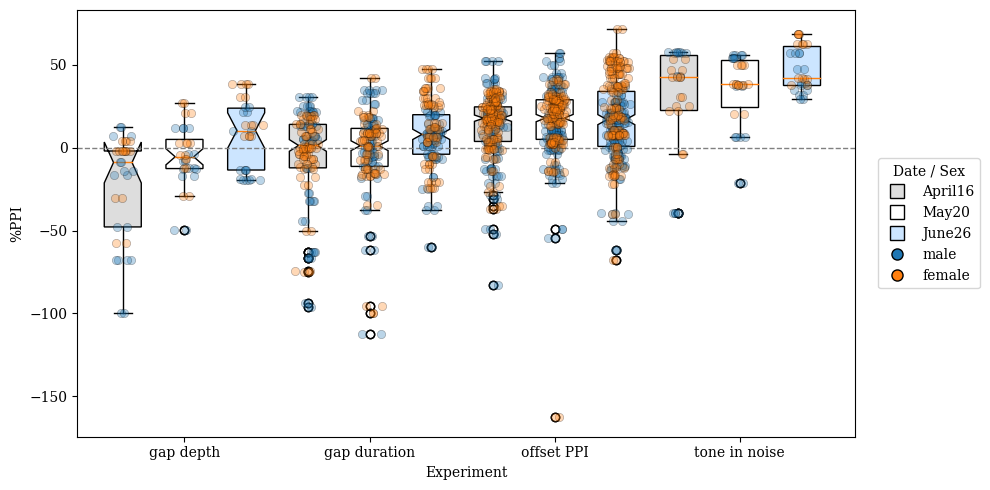

In [49]:
# ...existing code...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Use all_ppi (falls back to ppi_df / all_ppi created earlier in notebook)
df_source = None
for candidate in ('all_ppi', 'ppi_df', 'all_ppi_plot'):
    if candidate in globals():
        df_source = globals()[candidate].copy()
        break
if df_source is None:
    raise RuntimeError("all_ppi / ppi_df not found in workspace - run earlier cells to produce %PPI data.")

# Ensure we have sex column (map from animal if needed)
if 'sex' not in df_source.columns:
    df_source['sex'] = df_source['animal'].str.extract(r'(\d+)')[0].map(sex_dict)

# Load pooled experiment/date significance (if you still want to restrict to significant experiments)
try:
    test_date_pooled = pd.read_excel(os.path.join(output_dir, "TEST_DATE_POOLED_EXPERIMENT.xlsx"))
    sig_exps = test_date_pooled[test_date_pooled['significant'] == True]['variable'].unique().tolist()
except Exception:
    sig_exps = []  # fallback: don't filter

# experiments to plot (use significant list if available, else all experiments)
all_experiments = sorted(df_source['experiment'].dropna().unique())
if len(sig_exps) > 0:
    experiments = [e for e in all_experiments if e in sig_exps]
else:
    experiments = all_experiments

# dates and colors
dates = sorted(df_source['date'].dropna().unique(), key=lambda s: pd.to_datetime(s, errors='coerce') if pd.to_datetime(s, errors='coerce') is not pd.NaT else s)

if 'May20' in dates and 'June26' in dates:
    i_may = dates.index('May20')
    i_june = dates.index('June26')
    dates[i_may], dates[i_june] = dates[i_june], dates[i_may]
    
date_colors = ['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC']
date_colors = [date_colors[i % len(date_colors)] for i in range(len(dates))]

# Build data arrays per (experiment, date)
data = []
positions = []
labels = []
box_colors = []
exp_for_data = []                 # <-- track which experiment each data item belongs to
for i, exp in enumerate(experiments):
    for j, date in enumerate(dates):
        vals = df_source[(df_source['experiment'] == exp) & (df_source['date'] == date)]['percent_ppi'].dropna()
        # keep raw %PPI (exclude extreme invalids if desired)
        vals = vals[~np.isinf(vals)]
        data.append(vals.values.tolist())      # matplotlib ignores empty lists
        exp_for_data.append(exp)               # <-- record experiment for this data index
        pos = i * len(dates) + j
        positions.append(pos)
        labels.append(exp if j == 0 else "")
        box_colors.append(date_colors[j])

plt.figure(figsize=size)
min_for_notch = 3  # require at least this many samples to draw a notch reliably
counts = [len(d) for d in data]

# force tone_in_noise to be non-notched, and treat very small groups as non-notched
idx_nonotch = [i for i,c in enumerate(counts) if (0 < c < min_for_notch) or exp_for_data[i] == 'tone_in_noise']
# notched indices are those with enough samples and not forced non-notch
idx_notch = [i for i,c in enumerate(counts) if (c >= min_for_notch) and (exp_for_data[i] != 'tone_in_noise')]

# Draw notched boxes (if any)
box_patches = []
colors_order = []
if idx_notch:
    data_notch = [data[i] for i in idx_notch]
    pos_notch = [positions[i] for i in idx_notch]
    colors_notch = [box_colors[i] for i in idx_notch]
    bp_notch = plt.boxplot(data_notch, positions=pos_notch, widths=0.6, patch_artist=True, notch=True, manage_ticks=False)
    box_patches.extend(bp_notch.get('boxes', []))
    colors_order.extend(colors_notch)

# Draw non-notched boxes (if any) so tone_in_noise or other small groups don't get odd notches
if idx_nonotch:
    data_nonotch = [data[i] for i in idx_nonotch]
    pos_nonotch = [positions[i] for i in idx_nonotch]
    colors_nonotch = [box_colors[i] for i in idx_nonotch]
    bp_nonotch = plt.boxplot(data_nonotch, positions=pos_nonotch, widths=0.6, patch_artist=True, notch=False, manage_ticks=False)
    box_patches.extend(bp_nonotch.get('boxes', []))
    colors_order.extend(colors_nonotch)

# Color the drawn boxes in the same order we collected them
for patch, color in zip(box_patches, colors_order):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')


# overlay points colored by sex with jitter
color_map = {'male': male_col, 'female': female_col}
plotted_sexes = set()
jitter_scale = 0.08
point_alpha = 0.3
point_size = 36

for i, exp in enumerate(experiments):
    for j, date in enumerate(dates):
        pos = i * len(dates) + j
        rows = df_source[(df_source['experiment'] == exp) & (df_source['date'] == date)][['percent_ppi', 'sex']].dropna(subset=['percent_ppi'])
        if rows.empty:
            continue
        for sex, color in color_map.items():
            srows = rows[rows['sex'] == sex]
            if srows.empty:
                continue
            x = np.random.normal(loc=pos, scale=jitter_scale, size=len(srows))
            label = sex if sex not in plotted_sexes else None
            plt.scatter(x, srows['percent_ppi'], color=color, edgecolor='black', linewidth=0.5,
                        alpha=point_alpha, label=label, zorder=6, s=point_size)
            if label is not None:
                plotted_sexes.add(sex)

# X ticks and labels (center experiment groups)
if len(dates) > 0 and len(experiments) > 0:
    xticks = [i * len(dates) + (len(dates) - 1) / 2.0 for i in range(len(experiments))]
    plt.xticks(xticks, [e.replace('_', ' ') for e in experiments])

plt.ylabel('%PPI')
plt.xlabel('Experiment')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# legend: dates (colored squares) + sexes
date_handles = []
for idx, d in enumerate(dates):
    date_handles.append(plt.Line2D([0], [0], color='black', marker='s', markersize=10,
                                   markerfacecolor=date_colors[idx], linestyle='None', label=str(d)))
sex_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['male'], markeredgecolor='black', markersize=8, label='male'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['female'], markeredgecolor='black', markersize=8, label='female'),
]
handles = date_handles + sex_handles
plt.legend(handles=handles, title='Date / Sex', bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.tight_layout()

# save (use helper if available)

export_folder = r"C:\Users\Galahad\Desktop\Thesis\images"

""" plt.gcf().savefig(os.path.join(export_folder, "PPI_date.pgf"), format="pgf", bbox_inches="tight") """

plt.show()
# ...existing code...